### Packages

In [1]:
!pip install gco-wrapper


In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms #transforms.ToTensor() changes image to tensor
import torchvision.models as models
import matplotlib.pyplot as plt
import math
import pickle
import mixup
from mixup import mixup_graph

os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
# define the print function
def print_fig(input, target=None, title=None, save_dir=None):
    fig, axes = plt.subplots(1,len(input),figsize=(3*len(input),3))
    if title:
        fig.suptitle(title, size=16)
    if len(input) == 1 :
        axes = [axes]
        
    for i, ax in enumerate(axes):
        if len(input.shape) == 4:
            ax.imshow(input[i].permute(1,2,0).numpy())
        else :
            ax.imshow(input[i].numpy(), cmap='gray', vmin=0., vmax=1.)
        
        if target is not None:
            output = net((input[i].unsqueeze(0) - mean)/std)
            loss = criterion(output, target[i:i+1])
            ax.set_title("loss: {:.3f}\n pred: {}\n true : {}".format(loss, CIFAR100_LABELS_LIST[output.max(1)[1][0]], CIFAR100_LABELS_LIST[target[i]]))
        ax.axis('off')
    plt.subplots_adjust(wspace = 0.1)
    
    if save_dir is not None:
        plt.savefig(save_dir, bbox_inches = 'tight',  pad_inches = 0)
        
    plt.show()

### Model, Data, Saliency

In [ ]:
''' Model '''
resnet = models.resnet18(pretrained=True)
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
mean_torch = mean.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
std_torch = std.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)

resnet.eval()
criterion = nn.CrossEntropyLoss()

c:\Users\wangz\anaconda3\envs\xai\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\wangz\anaconda3\envs\xai\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from PIL import Image
img = Image.open("imagenet50\\testset\\ILSVRC2012_val_00000318.JPEG")
#img.show()

In [ ]:
import pandas as pd
raw_csv_data = pd.read_csv("img_name_label_testset.csv")
print(raw_csv_data)
raw_csv_data.shape

ModuleNotFoundError: No module named 'pandas'

In [ ]:
import csv

with open('img_name_label_testset.csv') as file_obj:
      
    reader_obj = csv.reader(file_obj)
    for row in reader_obj:
        try:
            if row[1] == 'ILSVRC2012_val_00000318.JPEG':
                value1=row[3]
            elif  row[1] == 'ILSVRC2012_val_00004095.JPEG':
                value2=row[3]
            elif  row[1] == 'ILSVRC2012_val_00013771.JPEG':
                value3=row[3]
            elif  row[1] == 'ILSVRC2012_val_00025969.JPEG':
                value4=row[3]
            elif  row[1] == 'ILSVRC2012_val_00032644.JPEG':
                value5=row[3]

        except:
            continue

#print(value1,value2,value3,value4,value5)
label1=int(value1)
print(label1)
#moshkele namayesh ?
data_dir = '/content/sample_data/images'

#print_fig(data_dir)

7


In [ ]:
test_transform = transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(254),
          transforms.ToTensor(),# akaharesh beyad Tensor koni dar pytorch va garna image khali nemigire
          transforms.Normalize(mean=mean, std=std)])
    
img1 = Image.open("/content/sample_data/images/ILSVRC2012_val_00000318.JPEG")
img2 = Image.open("/content/sample_data/images/ILSVRC2012_val_00004095.JPEG")
img3 = Image.open("/content/sample_data/images/ILSVRC2012_val_00013771.JPEG")
img4 = Image.open("/content/sample_data/images/ILSVRC2012_val_00025969.JPEG")
img5 = Image.open("/content/sample_data/images/ILSVRC2012_val_00032644.JPEG")
img11=test_transform(img1)
img21=test_transform(img2)
img21.shape

torch.Size([3, 254, 254])

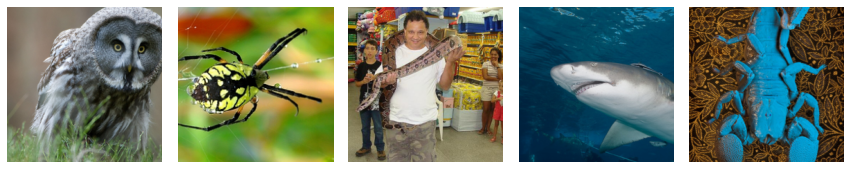

torch.Size([5, 3, 224, 224])

In [ ]:
''' Data: tiny imagenet with transform '''
img_exists = True 

if img_exists:
    # I used this codes to load data
    test_transform = transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),# akaharesh beyad Tensor koni dar pytorch va garna image khali nemigire
          transforms.Normalize(mean=mean, std=std)])
    

    sample_num = 5
    img1 = Image.open("/content/sample_data/images/ILSVRC2012_val_00000318.JPEG")
    img2 = Image.open("/content/sample_data/images/ILSVRC2012_val_00004095.JPEG")
    img3 = Image.open("/content/sample_data/images/ILSVRC2012_val_00013771.JPEG")
    img4 = Image.open("/content/sample_data/images/ILSVRC2012_val_00025969.JPEG")
    img5 = Image.open("/content/sample_data/images/ILSVRC2012_val_00032644.JPEG")
    tensor1=test_transform(img1)
    tensor2=test_transform(img2)
    tensor3=test_transform(img3)
    tensor4=test_transform(img4)
    tensor5=test_transform(img5)
    #data_dir = '/content/sample_data/images'
     # mitooni in address ro avaz koni
    #val_dset = data_dir.ToTensor() # transform (callable, optional) – A function/transform that takes in an PIL image and returns a transformed version. E.g, transforms.RandomCrop
    #val_loader = torch.utils.data.DataLoader(val_dset, batch_size=sample_num, shuffle=False, num_workers=2)
    ### Selected Examples
    input_sp = torch.stack([tensor1, tensor2, tensor3, tensor4, tensor5], dim=0)# dar tinyImagent har 500 ta ax class avaz mishe va dar kol 200 class dare yani 10000 images
    targets = torch.tensor([int(value1), int(value2), int(value3), int(value4), int(value5)])

   
else: # ma azin estefade kardim
    sample_num = 5
    # I saved the processed images at figures folder
    with open('sample.data', 'rb') as file:
        input_sp, targets = pickle.load(file)
    
print_fig((input_sp * std_torch + mean_torch)[:sample_num])
input_sp.shape

ghablen in sample.data be code haye zir save shode dar yak file dg:
with open('sample', 'wb') as file: # wb:writable binary
    pickle.dump(XXX, file)# dump to save 
ke in xx dar veghe yek variable hast ke image ha toosh rikchte shode mesle in boode:
input_sp = torch.stack([val_dset[3*50][0], val_dset[14*50][0], val_dset[269*50+2][0], val_dset[301*50+0][0], val_dset[388*50+2][0]], dim=0) 
targets = torch.tensor([val_dset[3*50][1], val_dset[14*50][1], val_dset[269*50+2][1], val_dset[301*50+0][1], val_dset[388*50+2][1]])

ke baadesh har do ro rikhte tooye in sample.

hal abaray open kardansheoon inja:

import pickle

# open a file, where you stored the pickled data
file = open('important', 'rb')

# dump information to that file
data = pickle.load(file)

# close the file
file.close()

print('Showing the pickled data:')

baraye solve:
https://towardsdatascience.com/pytorch-ignite-classifying-tiny-imagenet-with-efficientnet-e5b1768e5e8f#:~:text=Tiny%20ImageNet%20is%20a%20subset,images%2C%20and%2050%20test%20images.

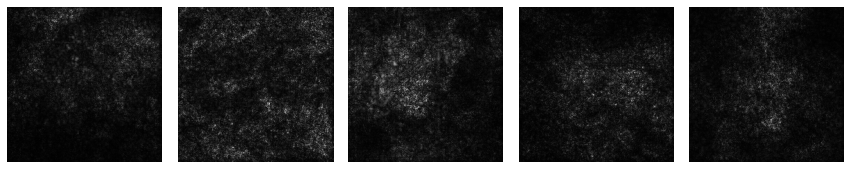

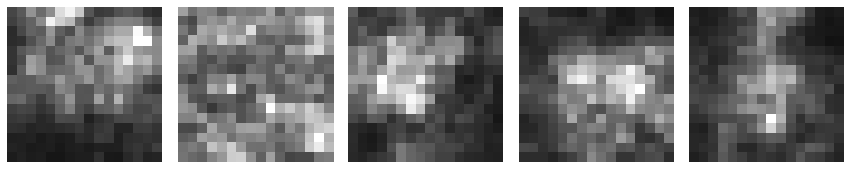

torch.Size([5, 224, 224])

In [ ]:
''' Saliency '''
input_var = input_sp[:sample_num].clone().detach().requires_grad_(True)
output = resnet(input_var)
loss = criterion(output, targets[:sample_num])
loss.backward()

unary = torch.sqrt(torch.mean(input_var.grad **2, dim=1))  
unary = unary / unary.view(sample_num, -1).max(1)[0].view(sample_num, 1, 1)
print_fig(unary)

unary16 = F.avg_pool2d(unary, 224//16)
unary16 = unary16 / unary16.view(sample_num, -1).max(1)[0].view(sample_num, 1, 1)
print_fig(unary16)
unary.shape

### Puzzle Mix

/content/mixup.py:295: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  mask = torch.tensor(mask, dtype=torch.float32, device=device)


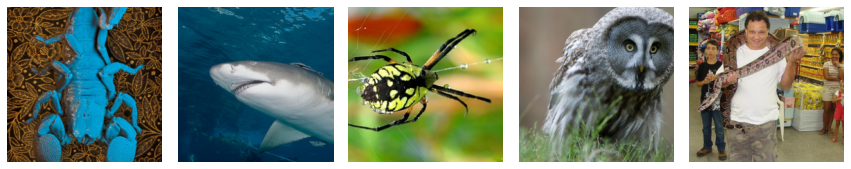

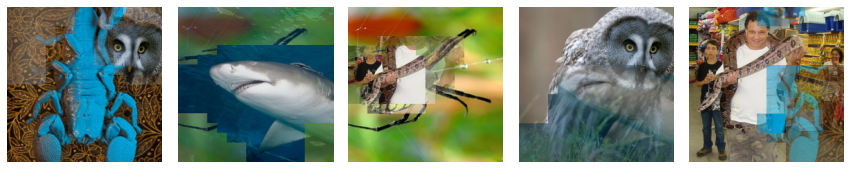

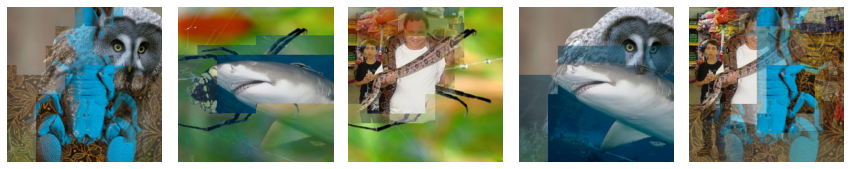

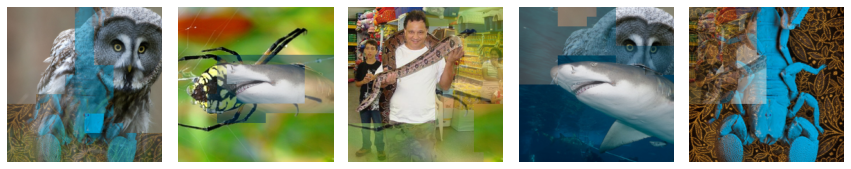

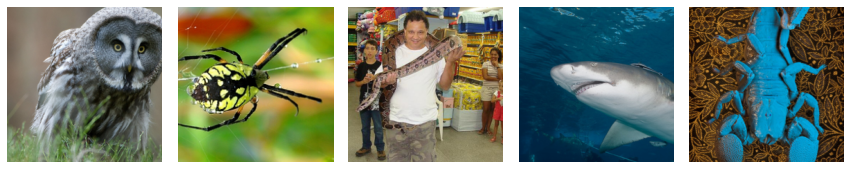

In [ ]:
''' Alpha Sweep'''
indices = [4,3,1,0,2]

n_labels = 3
block_num = 16

alpha = 0.5
beta = 0.8
gamma = 1.0
eta = 0.2

transport = False

for alpha in np.linspace(0,1,5):
    output = mixup_graph(input_sp, unary, indices=indices, n_labels=n_labels,
                         block_num=block_num, alpha=np.array([alpha]).astype('float32'), beta=beta, gamma=gamma, eta=eta,
                         neigh_size=2, mean=mean_torch, std=std_torch, 
                         transport=transport, t_eps=0.8, t_size=16, 
                         device='cpu')

    print_fig(output[0] * std_torch + mean_torch)

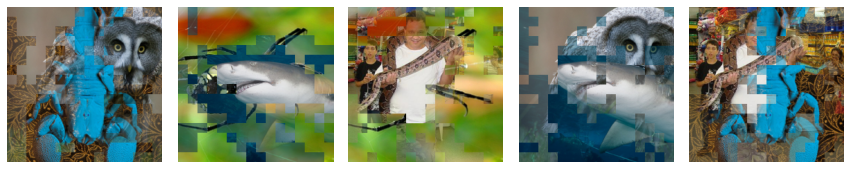

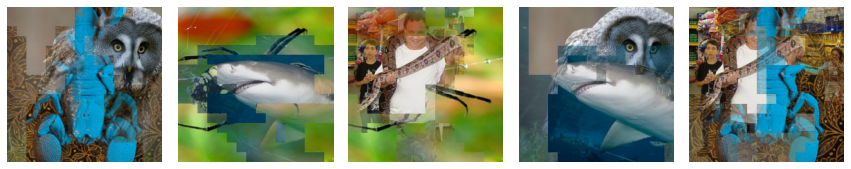

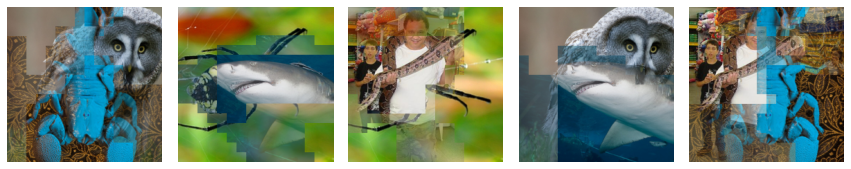

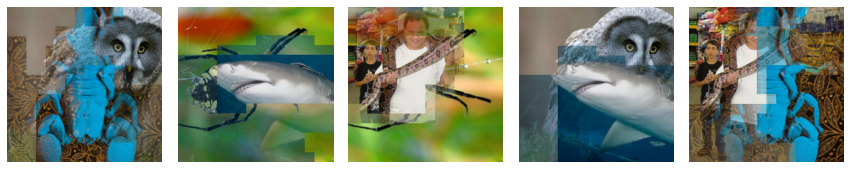

In [ ]:
''' Beta Sweep'''
indices = [4,3,1,0,2]

n_labels = 3
block_num = 16

alpha = 0.5
gamma = 0.
eta = 0.2

transport = False

for beta in np.linspace(0,0.8,4):
    output = mixup_graph(input_sp, unary, indices=indices, n_labels=n_labels,
                         block_num=block_num, alpha=np.array([alpha]).astype('float32'), beta=beta, gamma=gamma, eta=eta,
                         neigh_size=2, mean=mean_torch, std=std_torch, 
                         transport=transport, t_eps=0.8, t_size=16, 
                         device='cpu')

    print_fig(output[0] * std_torch + mean_torch)

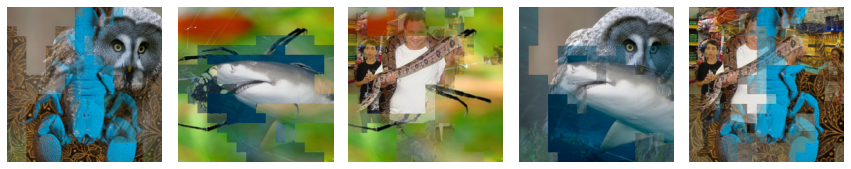

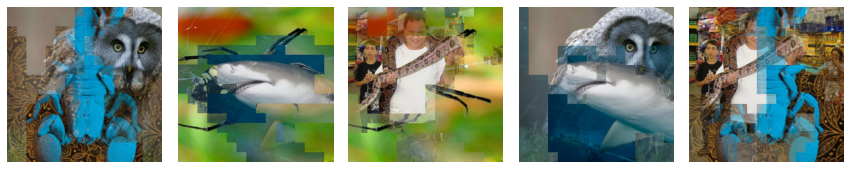

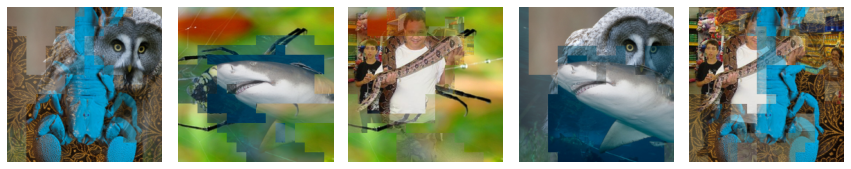

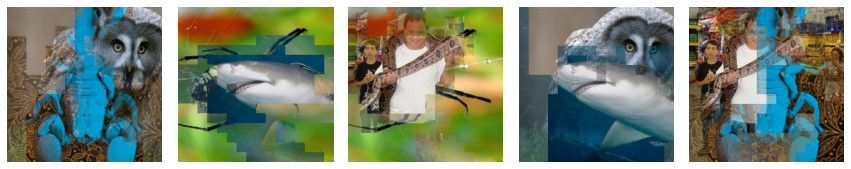

In [ ]:
''' Gamma Sweep'''
indices = [4,3,1,0,2]

n_labels = 3
block_num = 16

alpha = 0.5
beta = 0.2
eta = 0.2

transport = False

for gamma in np.linspace(0,2,4):
    output = mixup_graph(input_sp, unary, indices=indices, n_labels=n_labels,
                         block_num=block_num, alpha=np.array([alpha]).astype('float32'), beta=beta, gamma=gamma, eta=eta,
                         neigh_size=2, mean=mean_torch, std=std_torch, 
                         transport=transport, t_eps=0.8, t_size=16, 
                         device='cpu')

    print_fig(output[0] * std_torch + mean_torch)

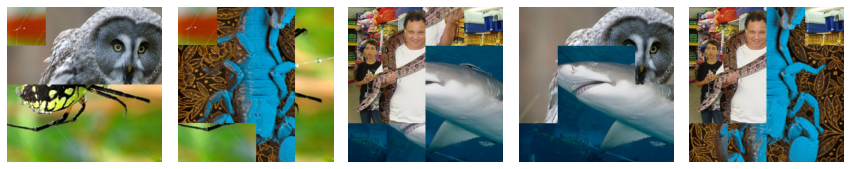

tensor([0.4375, 0.4375, 0.5000, 0.5625, 0.5625])


In [ ]:
''' Transport '''
indices = [1,4,3,0,2]

n_labels = 2
block_num = 4

alpha = 0.4
beta = 0.2
gamma = 1.0
eta = 0.2

transport = True
t_eps=0.2
t_size=224//block_num

output = mixup_graph(input_sp, unary, indices=indices, n_labels=n_labels,
                     block_num=block_num, alpha=np.array([alpha]).astype('float32'), beta=beta, gamma=gamma, eta=eta,
                     neigh_size=2, mean=mean_torch, std=std_torch, 
                     transport=transport, t_eps=t_eps, t_size=t_size, 
                     device='cpu')

print_fig(output[0] * std_torch + mean_torch)
print(output[1])

In [ ]:
tup = output
print ("your tuple is: ")
for i in tup:
   print( i , sep = " " )

your tuple is: 
tensor([[[[ 1.0502,  1.0673,  1.0844,  ...,  0.1426,  0.1768,  0.1597],
          [ 1.0502,  1.0844,  1.1015,  ...,  0.1426,  0.1426,  0.1768],
          [ 1.0502,  1.0844,  1.0844,  ...,  0.1254,  0.1254,  0.1597],
          ...,
          [ 0.4679,  0.4851,  0.5193,  ...,  0.0227,  0.0398,  0.0741],
          [ 0.4851,  0.5022,  0.5193,  ..., -0.0287, -0.0458, -0.0801],
          [ 0.4679,  0.5022,  0.5193,  ..., -0.0287, -0.0116,  0.0056]],

         [[ 1.3606,  1.3782,  1.3782,  ...,  0.2227,  0.2227,  0.2227],
          [ 1.3431,  1.3431,  1.3256,  ...,  0.2052,  0.2052,  0.2052],
          [ 1.3081,  1.3081,  1.2906,  ...,  0.2052,  0.2052,  0.2227],
          ...,
          [ 0.9930,  0.9930,  1.0105,  ...,  0.6954,  0.7304,  0.7129],
          [ 1.0105,  1.0280,  1.0455,  ...,  0.6604,  0.6254,  0.5728],
          [ 1.0630,  1.0455,  1.0280,  ...,  0.6779,  0.6604,  0.6604]],

         [[ 1.5071,  1.4897,  1.5071,  ...,  0.1128,  0.1302,  0.1651],
          [ 1.